In [42]:
import torch.nn.functional as F
import torch
import torchvision
from matplotlib import pyplot as plt

In [43]:
root_dir = './'
torchvision.datasets.MNIST(root=root_dir,download=True)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train

In [44]:
# Load MNIST dataset
train_set = torchvision.datasets.MNIST(root=root_dir, download=True, train=True)
test_set = torchvision.datasets.MNIST(root=root_dir, download=True, train=False)

In [45]:
# Dataset len
num_train = len(train_set)
num_test = len(test_set)
print(f"Num. training samples: {num_train}")
print(f"Num. test samples:     {num_test}")

Num. training samples: 60000
Num. test samples:     10000


In [46]:
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [47]:
# extract data and targets
x_train, y_train=train_set.data,train_set.targets
print(x_train.shape)
print(y_train.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


In [48]:
# add a dimension to tensor to become B*C*H*W
if len(x_train.shape)==3:
  x_train=x_train.unsqueeze(1)
print(x_train.shape)

torch.Size([60000, 1, 28, 28])


In [49]:
def show(img):
  # convert tensor to numpy array
  npimg = img.numpy()
  # Convert to H*W*C shape
  npimg_tr=np.transpose(npimg, (1,2,0))
  plt.imshow(npimg_tr,interpolation='nearest')

torch.Size([3, 152, 242])


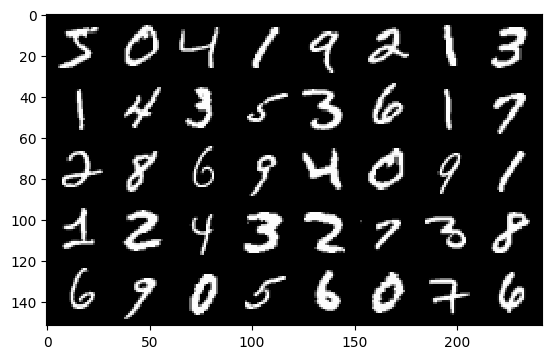

In [50]:
# make a grid of 40 images, 8 images per row
x_grid=utils.make_grid(x_train[:40], nrow=8, padding=2)
print(x_grid.shape)
# call helper function
show(x_grid)

In [51]:
# List of indexes on the training set
train_idx = list(range(num_train))

# List of indexes of the test set
test_idx = list(range(num_test))

In [52]:
# Shuffle the training set
import random

random.shuffle(train_idx)
for i in range(10):
  print(train_idx[i])

35929
54272
15375
31914
49894
59016
26860
53455
3783
46225


In [53]:
# Fraction of the original train set that we want to use as validation set
val_frac = 0.1
# Number of samples of the validation set
num_val = int(num_train * val_frac) 
num_train = num_train - num_val

# Split training set
val_idx = train_idx[num_train:]
train_idx = train_idx[:num_train]

print(f"{num_train} samples used as train set")
print(f"{num_val}  samples used as val set")

54000 samples used as train set
6000  samples used as val set


In [54]:
len(train_idx)

54000

In [55]:
from torchvision import transforms

# Compose transformations
data_transform = transforms.Compose([
  transforms.Resize(32),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
])

test_transform = transforms.Compose([
  transforms.Resize(32),
  transforms.ToTensor(),
])
# Load MNIST dataset with transforms
train_set = torchvision.datasets.MNIST(root=root_dir, train=True, download=True, transform=data_transform)
test_set = torchvision.datasets.MNIST(root=root_dir, train=False, download=True, transform=test_transform)

Label: 0


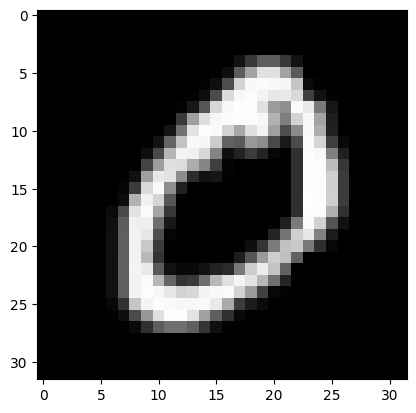

In [56]:
image, label = train_set[1]
plt.imshow(image.squeeze(), cmap='gray')
print('Label:', label)

In [57]:
# Split train_dataset into training and validation
from torch.utils.data import Subset

val_set = Subset(train_set, val_idx)
train_set = Subset(train_set, train_idx)

In [58]:
# Define loaders
from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, batch_size=64, num_workers=2, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_set,   batch_size=64, num_workers=2, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_set,  batch_size=64, num_workers=2, shuffle=False, drop_last=False)

In [59]:
import torch.nn as nn

In [60]:
class VGGBlock(nn.Module): # VGG model
    def __init__(self, in_channels, out_channels,batch_norm=False):

        super().__init__()

        conv2_params = {'kernel_size': (3, 3),
                        'stride'     : (1, 1),
                        'padding'   : 1
                        }

        noop = lambda x : x

        self._batch_norm = batch_norm

        self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=out_channels , **conv2_params)
        self.bn1 = nn.BatchNorm2d(out_channels) if batch_norm else noop
        #self.bn1 = nn.GroupNorm(32, out_channels) if batch_norm else noop

        self.conv2 = nn.Conv2d(in_channels=out_channels,out_channels=out_channels, **conv2_params)
        self.bn2 = nn.BatchNorm2d(out_channels) if batch_norm else noop
        #self.bn2 = nn.GroupNorm(32, out_channels) if batch_norm else noop

        self.max_pooling = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    @property
    def batch_norm(self):
        return self._batch_norm

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.max_pooling(x)

        return x

In [62]:
# Create the model
model = VGG16((1,32,32),batch_norm=True)
print(model)

VGG16(
  (block_1): VGGBlock(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pooling): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): VGGBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pooling): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): VGGBlock(
    (conv1): Conv2d(128,

In [63]:
# Get an element from the dataset
test_x, _ = train_set[0] # each element of the dataset is a couple (image, label)
# Get the size of a sample
test_x.size()
test_x = test_x.unsqueeze(dim=0)
test_x.size()
output=model(test_x)
output.shape

torch.Size([1, 512, 2, 2])

In [64]:
class VGG16(nn.Module): #VGG 16 model

  def __init__(self, input_size, num_classes=10,batch_norm=False):
    super(VGG16, self).__init__()

    self.in_channels,self.in_width,self.in_height = input_size

    self.block_1 = VGGBlock(self.in_channels,64,batch_norm=batch_norm)
    self.block_2 = VGGBlock(64, 128,batch_norm=batch_norm)
    self.block_3 = VGGBlock(128, 256,batch_norm=batch_norm)
    self.block_4 = VGGBlock(256,512,batch_norm=batch_norm)

    self.classifier = nn.Sequential(
            nn.Linear(2048, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.65),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.65),
            nn.Linear(4096, num_classes) 
        )

  @property
  def input_size(self):
      return self.in_channels,self.in_width,self.in_height

  def forward(self, x):

    x = self.block_1(x)
    x = self.block_2(x)
    x = self.block_3(x)
    x = self.block_4(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)

    return x

In [65]:
# Create the model
model = VGG16((1,32,32), batch_norm=True)
output = model(test_x)
output.shape

torch.Size([1, 10])

In [66]:
torch.cuda.is_available()
dev = torch.device('cuda')
print(dev)
# Define an optimizier
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr = 0.01)
# Define a loss 
criterion = nn.CrossEntropyLoss()

cuda


In [67]:
def train(net, loaders, optimizer, criterion, epochs=20, dev=dev, save_param = False, model_name="valerio"): # train
    try:
        net = net.to(dev)
        #print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Store the best val accuracy
        best_val_accuracy = 0

        # Process each epoch
        for epoch in range(10):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                if split == "train":
                  net.train()
                else:
                  net.eval()
                # Process each batch
                for (input, labels) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    #pred = pred.squeeze(dim=1) # Output shape is [Batch size, 1], but we want [Batch size]
                    #labels = labels.unsqueeze(1)
                    labels = labels.long()
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    #pred_labels = pred.argmax(1) + 1
                    #pred_labels = (pred >= 0.5).long() # Binarize predictions to 0 and 1
                    _,pred_label = torch.max(pred, dim = 1)
                    pred_labels = (pred_label == labels).float()

                    batch_accuracy = pred_labels.sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}

            # Store params at the best validation accuracy
            if save_param and epoch_accuracy["val"] > best_val_accuracy:
              #torch.save(net.state_dict(), f"{net.__class__.__name__}_best_val.pth")
              torch.save(net.state_dict(), f"{model_name}_best_val.pth")
              best_val_accuracy = epoch_accuracy["val"]

            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

In [68]:
# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

Epoch 1: TrL=0.3618, TrA=0.8852, VL=0.0812, VA=0.9724, TeL=0.0684, TeA=0.9772,
Epoch 2: TrL=0.0798, TrA=0.9751, VL=0.0572, VA=0.9830, TeL=0.0450, TeA=0.9847,
Epoch 3: TrL=0.0590, TrA=0.9815, VL=0.0594, VA=0.9808, TeL=0.0510, TeA=0.9823,
Epoch 4: TrL=0.0449, TrA=0.9857, VL=0.0395, VA=0.9863, TeL=0.0417, TeA=0.9857,
Epoch 5: TrL=0.0340, TrA=0.9890, VL=0.0490, VA=0.9835, TeL=0.0448, TeA=0.9858,
Epoch 6: TrL=0.0306, TrA=0.9908, VL=0.0393, VA=0.9876, TeL=0.0335, TeA=0.9900,
Epoch 7: TrL=0.0248, TrA=0.9923, VL=0.0342, VA=0.9886, TeL=0.0294, TeA=0.9905,
Epoch 8: TrL=0.0215, TrA=0.9936, VL=0.0303, VA=0.9906, TeL=0.0309, TeA=0.9894,
Epoch 9: TrL=0.0197, TrA=0.9939, VL=0.0357, VA=0.9896, TeL=0.0349, TeA=0.9898,
Epoch 10: TrL=0.0164, TrA=0.9949, VL=0.0376, VA=0.9887, TeL=0.0311, TeA=0.9900,


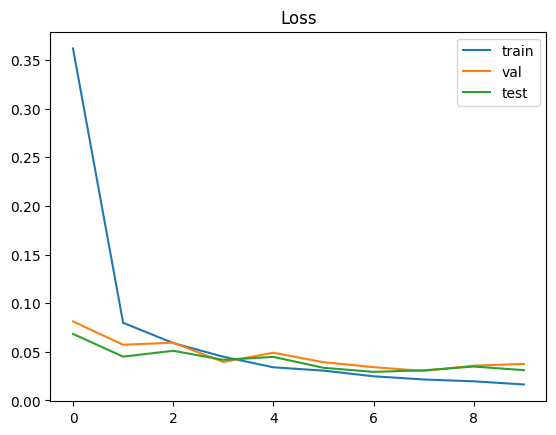

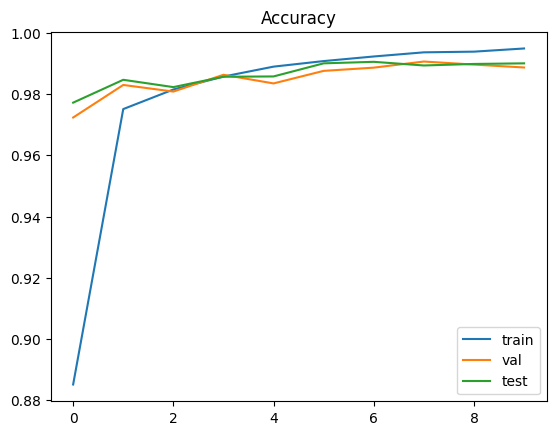

In [69]:
# Train model
train(model, loaders, optimizer, criterion, epochs=10, dev=dev)

In [70]:
list(enumerate(model.modules())) #check VGG16's component again

[(0,
  VGG16(
    (block_1): VGGBlock(
      (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (max_pooling): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (block_2): VGGBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (max_pooling): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (block_3

In [71]:
# Test a Default Accuracy
import random 
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random 
test_loss = 0
correct = 0
test_losses=[]
test_losses=[]
test_accuracy=[]
for data, target in test_loader:
    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
        
    
test_loss /= len(test_loader.dataset)
test_losses.append(test_loss)
acc1=100. * float(correct.to(torch.device('cpu')).numpy())
print('\nTest result: Average loss: {:.4f}, Accuracy: {:.4f}%\n'.format(
    test_loss, acc1 / len(test_loader.dataset)))
    
test_accuracy.append(acc1 / len(test_loader.dataset))

/tmp/ipykernel_2224715/1190017113.py:19: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)



Test result: Average loss: 0.0313, Accuracy: 99.0000%



In [72]:
(list(enumerate(model.modules()))[0][1].classifier[0]).weight.shape

torch.Size([4096, 2048])

In [74]:

correct_hist = []
sh = (list(enumerate(model.modules()))[0][1].classifier[0]).weight.shape
layer = (list(enumerate(model.modules()))[0][1].classifier[0]).weight

#num=int(4098*4098*(1/20))


num = 10
temp = 0
r = 0

with open("/home/swuser08/vgg16.txt", 'w') as f:
    for a in range(100): #total run NUM
        with torch.no_grad():
            test_loss = 0
            correct = 0
            test_losses=[]
            test_accuracy=[]
            r = random.randrange(0,num)
            temp = layer[v[r][0]][v[r][1]].clone()# copy the default value 
            layer[v[r][0]][v[r][1]] = 10**random.randrange(3, 10)#*random.randrange(10,20)      insert random weight value in random neruon which located in specific layer(fc1)        
            print("Fault injected: {:4d} {:4d} {:.5f}=>{:.5f}".format(v[r][0], v[r][1], v[r][2], layer[v[r][0]][v[r][1]].item()))
            print("Fault injected: {:4d} {:4d} {:.5f}=>{:.5f}".format(v[r][0], v[r][1], v[r][2], layer[v[r][0]][v[r][1]].item()), file=f)
            
            for data, target in test_loader:# do test with fault
                if torch.cuda.is_available():
                    data, target = data.cuda(), target.cuda()
                    data, target = Variable(data, volatile=True), Variable(target)
                    output = model(data)
                    test_loss += F.cross_entropy(output, target, size_average=False).item()
                    pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                    correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
                
            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)
            acc=100. * float(correct.to(torch.device('cpu')).numpy())
            print('\nTest result: Average loss: {:.4f}, Accuracy: {:.4f}%\n'.format(
                test_loss, acc / len(test_loader.dataset)))
            print('Fault Injected Test result: Average loss: {:.4f}, Accuracy: {:.4f}%'.format(
                test_loss, acc / len(test_loader.dataset)), file=f)
                
        for i in range(num): # Top n Neurons
            with torch.no_grad():
                # print(layer[v[i][0]][v[i][1]])
                test_loss = 0
                correct = 0
                test_losses=[]
                test_accuracy=[]
                target_temp = layer[v[i][0]][v[i][1]].clone() # save fault value at target_temp 
                print(layer[v[i][0]][v[i][1]])
    #            value=target.item() #save before value
                value=0
                layer[v[i][0]][v[i][1]] = 0            # change faulted value as 0 
                for data, target in test_loader:
                    data, target = Variable(data, volatile=True), Variable(target)
                    if torch.cuda.is_available():
                        data, target = data.cuda(), target.cuda()
                        data, target = Variable(data, volatile=True), Variable(target)
                        output = model(data)
                        test_loss += F.cross_entropy(output, target, size_average=False).item()
                        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
                        
                    
                test_loss /= len(test_loader.dataset)
                test_losses.append(test_loss)
                acc=100. * float(correct.to(torch.device('cpu')).numpy())
                print('{:4f} {:4f} Test result: Average loss: {:.4f}, Accuracy: {:.4f}%'.format(
                    a, i, test_loss, acc / len(test_loader.dataset)), file=f)
                print('{:4f} {:4f} Test result: Average loss: {:.4f}, Accuracy: {:.4f}%'.format(
                    a, i, test_loss, acc / len(test_loader.dataset)))

                test_accuracy.append(acc  / len(test_loader.dataset))
                correct_hist.append((i, j, correct, value)) # the highest value and weight changed to 0 /가장 높은 확률과, 0으로 바뀐 weight까           
                    
                layer[v[i][0]][v[i][1]] = target_temp  # insert faulted value a gain 
                if len(correct_hist) % 10 == 0:# check progress
                        print(correct_hist)
        with torch.no_grad():
            layer[v[r][0]][v[r][1]]=temp                #insert DEFAULT value a gain
        correct_hist = sorted(correct_hist, key = lambda x : abs(x[2]))  #sorting
        node_high = correct_hist[-1] # take index's max -> location, highest correct's time
        node_low = correct_hist[0]
        print('{} when high: {}'.format(a, node_high))
        print('{} when high: {}'.format(a, node_high),file=f)

        print('{} when low: {}'.format(a, node_low))
        print('{} when low: {}'.format(a, node_low),file=f)
        print('{} accuracy of the high network on the test images: {}'.format(a, node_high[2]/len(test_loader.dataset)*100))
        print('{} accuracy of the high network on the test images: {}'.format(a, node_high[2]/len(test_loader.dataset)*100),file=f)
        print('{} accuracy of the low network on the test images'.format(a, node_low[2]/len(test_loader.dataset)*100))
        print('{} accuracy of the low network on the test images'.format(a, node_low[2]/len(test_loader.dataset)*100),file=f)
        correct_hist = []

Fault injected: 3202  796 0.02658=>1000000000.00000


/tmp/ipykernel_2224715/3399276088.py:28: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)



Test result: Average loss: 34845998.9760, Accuracy: 12.3600%

tensor(0.0023, device='cuda:0', requires_grad=True)


/tmp/ipykernel_2224715/3399276088.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
/tmp/ipykernel_2224715/3399276088.py:58: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)


0.000000 0.000000 Test result: Average loss: 34845998.9760, Accuracy: 12.3600%
tensor(-0.0007, device='cuda:0', requires_grad=True)
0.000000 1.000000 Test result: Average loss: 34845998.9760, Accuracy: 12.3600%
tensor(-0.0164, device='cuda:0', requires_grad=True)
0.000000 2.000000 Test result: Average loss: 34845998.9760, Accuracy: 12.3600%
tensor(-0.0164, device='cuda:0', requires_grad=True)
0.000000 3.000000 Test result: Average loss: 34845998.9760, Accuracy: 12.3600%
tensor(1.0000e+09, device='cuda:0', requires_grad=True)
0.000000 4.000000 Test result: Average loss: 0.0313, Accuracy: 99.0000%
tensor(1.0000e+09, device='cuda:0', requires_grad=True)
0.000000 5.000000 Test result: Average loss: 0.0313, Accuracy: 99.0000%
tensor(0., device='cuda:0', requires_grad=True)
0.000000 6.000000 Test result: Average loss: 34845998.9760, Accuracy: 12.3600%
tensor(0., device='cuda:0', requires_grad=True)
0.000000 7.000000 Test result: Average loss: 34845998.9760, Accuracy: 12.3600%
tensor(-0.0045,

In [ ]:

correct_hist = []
sh = (list(enumerate(model.modules()))[0][1].classifier[0]).weight.shape
layer = (list(enumerate(model.modules()))[0][1].classifier[0]).weight

#num=int(4098*4098*(1/20))


num = 10
temp = 0
r = 0

with open("/home/swuser08/vgg16.txt", 'w') as f:
    for a in range(100):
        with torch.no_grad():
            test_loss = 0
            correct = 0
            test_losses=[]
            test_accuracy=[]
            r = random.randrange(0,num)
            temp = layer[v[r][0]][v[r][1]].clone()
            layer[v[r][0]][v[r][1]] = random.randrange(3, 1000)#*random.randrange(10,20)           
            print("Fault injected: {:4d} {:4d} {:.5f}=>{:.5f}".format(v[r][0], v[r][1], v[r][2], layer[v[r][0]][v[r][1]].item()))
            print("Fault injected: {:4d} {:4d} {:.5f}=>{:.5f}".format(v[r][0], v[r][1], v[r][2], layer[v[r][0]][v[r][1]].item()), file=f)
            
            for data, target in test_loader:
                if torch.cuda.is_available():
                    data, target = data.cuda(), target.cuda()
                    data, target = Variable(data, volatile=True), Variable(target)
                    output = model(data)
                    test_loss += F.cross_entropy(output, target, size_average=False).item()
                    pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                    correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
                
            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)
            acc=100. * float(correct.to(torch.device('cpu')).numpy())
            print('\nTest result: Average loss: {:.4f}, Accuracy: {:.4f}%\n'.format(
                test_loss, acc / len(test_loader.dataset)))
            print('Fault Injected Test result: Average loss: {:.4f}, Accuracy: {:.4f}%'.format(
                test_loss, acc / len(test_loader.dataset)), file=f)
                
        for i in range(num):
            with torch.no_grad():
                # print(layer[v[i][0]][v[i][1]])
                test_loss = 0
                correct = 0
                test_losses=[]
                test_accuracy=[]
                target_temp = layer[v[i][0]][v[i][1]].clone() # target에 저장
                print(layer[v[i][0]][v[i][1]])
    #            value=target.item() #이전값 저장
                value=0
                layer[v[i][0]][v[i][1]] = 0            
                for data, target in test_loader:
                    data, target = Variable(data, volatile=True), Variable(target)
                    if torch.cuda.is_available():
                        data, target = data.cuda(), target.cuda()
                        data, target = Variable(data, volatile=True), Variable(target)
                        output = model(data)
                        test_loss += F.cross_entropy(output, target, size_average=False).item()
                        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
                        
                    
                test_loss /= len(test_loader.dataset)
                test_losses.append(test_loss)
                acc=100. * float(correct.to(torch.device('cpu')).numpy())
                print('{:4f} {:4f} Test result: Average loss: {:.4f}, Accuracy: {:.4f}%'.format(
                    a, i, test_loss, acc / len(test_loader.dataset)), file=f)
                print('{:4f} {:4f} Test result: Average loss: {:.4f}, Accuracy: {:.4f}%'.format(
                    a, i, test_loss, acc / len(test_loader.dataset)))

                test_accuracy.append(acc  / len(test_loader.dataset))
                correct_hist.append((i, j, correct, value))  #가장 높은 확률과, 0으로 바뀐 weight까지            
                    
                layer[v[i][0]][v[i][1]] = target_temp  # 복구
                if len(correct_hist) % 10 == 0:
                        print(correct_hist)
        with torch.no_grad():
            layer[v[r][0]][v[r][1]]=temp                
        correct_hist = sorted(correct_hist, key = lambda x : abs(x[2]))  #sorting
        node_high = correct_hist[-1] #index의 max를 가져옴 -> 위치랑, 언제 가장 높은 correct 
        node_low = correct_hist[0]
        print('{} when high: {}'.format(a, node_high))
        print('{} when high: {}'.format(a, node_high),file=f)

        print('{} when low: {}'.format(a, node_low))
        print('{} when low: {}'.format(a, node_low),file=f)
        print('{} accuracy of the high network on the test images: {}'.format(a, node_high[2]/len(test_loader.dataset)*100))
        print('{} accuracy of the high network on the test images: {}'.format(a, node_high[2]/len(test_loader.dataset)*100),file=f)
        print('{} accuracy of the low network on the test images'.format(a, node_low[2]/len(test_loader.dataset)*100))
        print('{} accuracy of the low network on the test images'.format(a, node_low[2]/len(test_loader.dataset)*100),file=f)
        correct_hist = []

In [79]:
for k in range(100):    
    import random 
    import copy
    correct_hist = []
    sh = (list(enumerate(model.modules()))[0][1].classifier[0]).weight.shape
    layer = (list(enumerate(model.modules()))[0][1].classifier[0]).weight

    #num=int(4098*4098*(1/20))

    num = 100
    r = 0
    value = 0
    test_loss = 0
    correct = 0
    highest_acc=0.0
    highest_i=0  
    r = 10**random.randrange(3, 8380000)
    with torch.no_grad():
        
        temp = layer[v[r][0]][v[r][1]].clone()

        layer[v[r][0]][v[r][1]] = 10**random.randrange(3, 10)#*random.randrange(10,20) 
        print("Fault injected: {:4d} {:4d} {:.5f}=>{:.5f}".format(v[r][0], v[r][1], v[r][2], layer[v[r][0]][v[r][1]].item()))        
        r = random.randrange(0,8380000)
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
                data, target = Variable(data, volatile=True), Variable(target)
                output = model(data)
                test_loss += F.cross_entropy(output, target, size_average=False).item()
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
                
            
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        acc=100. * float(correct.to(torch.device('cpu')).numpy())
        print('\nFAULTED result: Average loss: {:.4f}, Accuracy: {:.4f}%\n'.format(
            test_loss, acc / len(test_loader.dataset)))
            
        test_accuracy.append(acc / len(test_loader.dataset))          
    if((acc / len(test_loader.dataset))< (90*(acc1 / len(test_loader.dataset)))): # if acc is lower than test acc's 90% do CUZED method
        with torch.no_grad():
            for i in range(sh[0]):
                for j in range(sh[1]):
                    v.append([i, j, (list(enumerate(model.modules()))[0][1].classifier[0]).weight[i, j].item()])
                if i % 100 == 0:
                    print(i)
            v = sorted(v, key = lambda x : x[2])  #sorting
            v.reverse()
            from matplotlib import pyplot as plt
            plt.figure(figsize=(100,10))
            plt.plot(list(zip(*v[:10000:10]))[2])                    
            with open("/home/swuser08/vgg16mnist_final.txt", 'w') as f:
                with torch.no_grad():
                    test_loss = 0
                    correct = 0
                    print("Fault injected: {:4d} {:4d} {:.5f}=>{:.5f}".format(v[r][0], v[r][1], v[r][2], layer[v[r][0]][v[r][1]].item()))
                    print("Fault injected: {:4d} {:4d} {:.5f}=>{:.5f}".format(v[r][0], v[r][1], v[r][2], layer[v[r][0]][v[r][1]].item()), file=f)
                    
                    for data, target in test_loader:
                        if torch.cuda.is_available():
                            data, target = data.cuda(), target.cuda()
                            data, target = Variable(data, volatile=True), Variable(target)
                            output = model(data)
                            test_loss += F.cross_entropy(output, target, size_average=False).item()
                            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                            correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()    
                    test_loss /= len(test_loader.dataset)
                    test_losses.append(test_loss)
                    acc=100. * float(correct.to(torch.device('cpu')).numpy())
                    print('\nTest result: Average loss: {:.4f}, Accuracy: {:.4f}%\n'.format(
                        test_loss, acc / len(test_loader.dataset)))
                    print('Fault Injected Test result: Average loss: {:.4f}, Accuracy: {:.4f}%'.format(
                        test_loss, acc / len(test_loader.dataset)), file=f)
                        
                    test_accuracy.append(acc / len(test_loader.dataset))    
                    
                for i in range(10):
                    with torch.no_grad():
                        # print(layer[v[i][0]][v[i][1]])
                        test_loss = 0
                        correct = 0

            #            value=target.item() #이전값 저장
                        target_temp = layer[v[i][0]][v[i][1]].clone() # target에 저장
                        print(layer[v[i][0]][v[i][1]])
                        layer[v[i][0]][v[i][1]] = 0            
                        for data, target in test_loader:
                            data, target = Variable(data, volatile=True), Variable(target)
                            if torch.cuda.is_available():
                                data, target = data.cuda(), target.cuda()
                                data, target = Variable(data, volatile=True), Variable(target)
                                output = model(data)
                                test_loss += F.cross_entropy(output, target, size_average=False).item()
                                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                                correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()    
                        test_loss /= len(test_loader.dataset)
                        test_losses.append(test_loss)
                        acr =100. * float(correct.to(torch.device('cpu')).numpy())
                        print('{:4f} {:4f} Test result: Average loss: {:.4f}, Accuracy: {:.4f}%'.format(
                            test_loss, i, test_loss, acr / len(test_loader.dataset)), file=f)
                        print('{:4f} {:4f} Test result: Average loss: {:.4f}, Accuracy: {:.4f}%'.format(
                            test_loss, i, test_loss, acr / len(test_loader.dataset)))
                        test_accuracy.append(acr  / len(test_loader.dataset))
                        correct_hist.append((i, j, correct, value))  #가장 높은 확률과, 0으로 바뀐 weight까지            
                        rst= acr/len(test_loader.dataset)
                        if highest_acc > rst:#highest_acc에 문제 IFFFFF 고치기
                            highest_acc=highest_acc
                            print(highest_i)
                            print(highest_acc)
                        else:                        
                            highest_acc= copy.deepcopy(rst)
                            print('highest_acc check ', file=f)
                            print(highest_acc, file=f)
                            highest_layer= layer[v[i][0]][v[i][1]].clone()
                            print(highest_layer, file=f)
                            highest_i=i
                            print(highest_i, file=f)
                                
                        layer[v[i][0]][v[i][1]] = target_temp 

                            # 복구
                        if len(correct_hist) % 10 == 0:
                                print(correct_hist)
                            
                with torch.no_grad():
                    layer[v[highest_i][0]][v[highest_i][1]]=0                
                correct_hist = sorted(correct_hist, key = lambda x : abs(x[2]))  #sorting
                node_high = correct_hist[-1] #index의 max를 가져옴 -> 위치랑, 언제 가장 높은 correct 
                node_low = correct_hist[0]
                print('{} when high: {}'.format(test_loss, node_high))
                print('{} when high: {}'.format(test_loss, node_high),file=f)

                print('{} when low: {}'.format(test_loss, node_low))
                print('{} when low: {}'.format(test_loss, node_low),file=f)
                print('{} accuracy of the high network on the test images: {}'.format(test_loss, node_high[2]/len(test_loader.dataset)*100))
                print('{} accuracy of the high network on the test images: {}'.format(test_loss, node_high[2]/len(test_loader.dataset)*100),file=f)
                print('{} accuracy of the low network on the test images'.format(test_loss, node_low[2]/len(test_loader.dataset)*100))
                print('{} accuracy of the low network on the test images'.format(test_loss, node_low[2]/len(test_loader.dataset)*100),file=f)
                correct_hist = []
                
                test_loss = 0
                correct = 0
                for data, target in test_loader:
                    if torch.cuda.is_available():
                        data, target = data.cuda(), target.cuda()
                        data, target = Variable(data, volatile=True), Variable(target)
                        output = model(data)
                        test_loss += F.cross_entropy(output, target, size_average=False).item()
                        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
                        
                    
                test_loss /= len(test_loader.dataset)
                test_losses.append(test_loss)
                acc=100. * float(correct.to(torch.device('cpu')).numpy())
                print('\nMITIGATION result: Average loss: {:.4f}, Accuracy: {:.4f}%\n'.format(
                    test_loss, acc / len(test_loader.dataset), file=f))
                    
                test_accuracy.append(acc / len(test_loader.dataset))
                with torch.no_grad():
                    layer[v[r][0]][v[r][1]]=temp
                
                test_loss = 0
                correct = 0
                for data, target in test_loader:
                    if torch.cuda.is_available():
                        data, target = data.cuda(), target.cuda()
                        data, target = Variable(data, volatile=True), Variable(target)
                        output = model(data)
                        test_loss += F.cross_entropy(output, target, size_average=False).item()
                        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
                        
                    
                test_loss /= len(test_loader.dataset)
                test_losses.append(test_loss)
                acc=100. * float(correct.to(torch.device('cpu')).numpy())
                print('\nDEFAULT result: Average loss: {:.4f}, Accuracy: {:.4f}%\n'.format(
                    test_loss, acc / len(test_loader.dataset), file=f))
                    
                test_accuracy.append(acc / len(test_loader.dataset))
            

IndexError: cannot fit 'int' into an index-sized integer